# Jacobian Transpose Inverse Kinematics and Control

In this notebook, we'll demonstrate an extremely simple approach for computing basic inverse kinematics (IK) and controlling the position of some point on our robot using the Jacobian transpose. 

For a brief technical introduction, see <https://groups.csail.mit.edu/drl/journal_club/papers/033005/buss-2004.pdf> or <https://homes.cs.washington.edu/~todorov/courses/cseP590/06_JacobianMethods.pdf>

In [1]:
using RigidBodyDynamics
using StaticArrays

First we'll load our double pendulum robot from URDF:

In [2]:
urdf = Pkg.dir("RigidBodyDynamics", "test", "urdf", "Acrobot.urdf")

mechanism = parse_urdf(Float64, urdf)
state = MechanismState(mechanism)
mechanism

Spanning tree:
Vertex: world (root)
  Vertex: base_link, Edge: base_link_to_world
    Vertex: upper_link, Edge: shoulder
      Vertex: lower_link, Edge: elbow
No non-tree joints.

Now we choose a point on the robot to control. We'll pick the end of the second link, which is located 2m from the origin of the `lower_link` body:

In [3]:
const body = findbody(mechanism, "lower_link")
const point = Point3D(default_frame(body), 0., 0, -2)

Point3D in "after_elbow": [0.0, 0.0, -2.0]

Let's visualize the mechanism and its attached point. For visualization, we'll use [MeshCatMechanisms.jl](https://github.com/JuliaRobotics/MeshCatMechanisms.jl) with [Blink.jl](https://github.com/JunoLab/Blink.jl). 

(Note: the `#NBSKIP` comments are to skip these cells during `Pkg.test("RigidBodyDynamics")`)

In [4]:
#NBSKIP
using MeshCatMechanisms
using Blink

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='pkg/WebIO/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='pkg/WebIO/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [5]:
#NBSKIP
# Create the visualizer
const vis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
# Render our target point attached to the robot as a sphere with radius 0.07
setelement!(vis, point, 0.07)
# Open the visualizer in a new Blink window
open(vis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/.julia/v0.6/Blink/deps/atom/electron /home/rdeits/.julia/v0.6/Blink/src/AtomShell/main.js port 4134`, ProcessRunning), TCPSocket(RawFD(53) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(55) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#109),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 1, Nullable{Any}(true))))

## Inverse Kinematics

First, let's use the point jacobian to solve a simple inverse kinematics problem. Given a target location `desired` expressed in world frame, we want to find the joint angles `q` such that the `point` attached to the robot is at the desired location. 

To do that, we'll iteratively update `q` by applying: 

\begin{align}
\Delta q = \alpha \, J_p^\top \, \Delta p
\end{align}

where $\alpha$ is our step size (equivalent to a learning rate in gradient descent) and $\Delta p$ is the error in the position of our target point. 

In [6]:
function jacobian_transpose_ik!(state::MechanismState,
                               body::RigidBody,
                               point::Point3D,
                               desired::Point3D;
                               α=0.1,
                               iterations=100)
    mechanism = state.mechanism
    world = root_frame(mechanism)
    
    # Compute the joint path from world to our target body
    p = path(mechanism, root_body(mechanism), body)
    # Allocate the point jacobian (we'll update this in-place later)
    Jp = point_jacobian(state, p, transform(state, point, world))
    
    q = copy(configuration(state))
    
    for i in 1:iterations
        # Update the position of the point
        point_in_world = transform(state, point, world)
        # Update the point's jacobian
        point_jacobian!(Jp, state, p, point_in_world)
        # Compute an update in joint coordinates using the jacobian transpose
        Δq = α * Array(Jp)' * (transform(state, desired, world) - point_in_world).v
        # Apply the update
        q .= configuration(state) .+ Δq
        set_configuration!(state, q)
    end
    state
end

jacobian_transpose_ik! (generic function with 1 method)

To use our IK method, we just have to set our current state and choose a desired location for the tip of the robot's arm: 

In [7]:
rand!(state)

true

In [8]:
#NBSKIP
set_configuration!(vis, configuration(state))

In [9]:
# Choose a desired location. We'll move the tip of the arm to
# [0.5, 0, 2]
desired = Point3D(root_frame(mechanism), 0.5, 0, 2)
# Run the IK, updating `state` in place
jacobian_transpose_ik!(state, body, point, desired)

MechanismState{Float64, Float64, Float64, …}(…)

In [10]:
#NBSKIP
set_configuration!(vis, configuration(state))

In [11]:
# We asked for our point to be close to [0.5, 0, 2], 
# but since the arm cannot move in the y direction at all
# we end up near [0.5, 0.25, 2] instead
transform(state, point, root_frame(mechanism))

Point3D in "world": [0.500059, 0.25, 2.01016]

We can try varying the target and watching the IK solution change:

In [12]:
qs = typeof(configuration(state))[]

# Vary the desired x position from -1 to 1
for x in linspace(-1, 1, 100)
    desired = Point3D(root_frame(mechanism), x, 0, 2)
    jacobian_transpose_ik!(state, body, point, desired)
    push!(qs, copy(configuration(state)))
end

In [13]:
#NBSKIP
ts = collect(linspace(0, 1, length(qs)))
setanimation!(vis, ts, qs)

true

## Control

Now let's use the same principle to generate torques and actually control the robot. To make things more interesting, let's get the end of the robot's arm to trace out a circle. 

In [14]:
circle_origin = SVector(0., 0.25, 2)
radius = 0.5
ω = 1.0  # radians per second at which the point should move in its circle

1.0

In [15]:
#NBSKIP
using MeshCat
using GeometryTypes: Point

In [16]:
#NBSKIP

# Draw the circle in the viewer
θ = repeat(linspace(0, 2π, 100), inner=(2,))[2:end]
cx, cy, cz = circle_origin
geometry = PointCloud(Point.(cx .+ radius .* sin.(θ), cy, cz .+ 0.5 .* cos.(θ)))
setobject!(vis[:circle], LineSegments(geometry, LineBasicMaterial()))

MeshCat Visualizer with path /meshcat/circle

In [17]:
# This function will take in the parameters of the circle
# and the target point and return a function we can use
# as the controller. By wrapping the construction of the 
# controller in this way, we avoie any issues with accessing
# non-const global variables. 
function make_circle_controller(state::MechanismState,
                                body::RigidBody,
                                point::Point3D,
                                circle_origin::AbstractVector,
                                radius,
                                ω)
    mechanism = state.mechanism
    world = root_frame(mechanism)
    joint_path = path(mechanism, root_body(mechanism), body)
    Jp = point_jacobian(state, joint_path, transform(state, point, root_frame(mechanism)))
    v̇ = similar(velocity(state))
    
    function controller!(τ, t, state)
        desired = Point3D(world, circle_origin .+ radius .* SVector(sin(t / ω), 0, cos(t / ω)))
        point_in_world = transform_to_root(state, body) * point
        point_jacobian!(Jp, state, joint_path, point_in_world)
        Kp = 200
        Kd = 20
        Δp = desired - point_in_world
        v̇ .= Kp * Array(Jp)' * Δp.v .- 20 .* velocity(state)
        τ .= inverse_dynamics(state, v̇)
    end
end

make_circle_controller (generic function with 1 method)

In [18]:
controller! = make_circle_controller(state, body, point, circle_origin, radius, ω)

controller! (generic function with 1 method)

In [19]:
ts, qs, vs = simulate(state, 10, controller!);

In [20]:
#NBSKIP

# Animate the resulting trajectory
setanimation!(vis, ts, qs)

true

Now we can plot the behavior of the controller. The initial state is quite far from the target, so there's some significant overshoot early in the trajectory, but the controller eventually settles into tracking the desired circular path. This controller isn't very well-tuned, and we could certainly do better with a more advanced approach, but this is still a nice demonstration of a very simple control policy. 

In [21]:
using Plots; gr()

Plots.GRBackend()

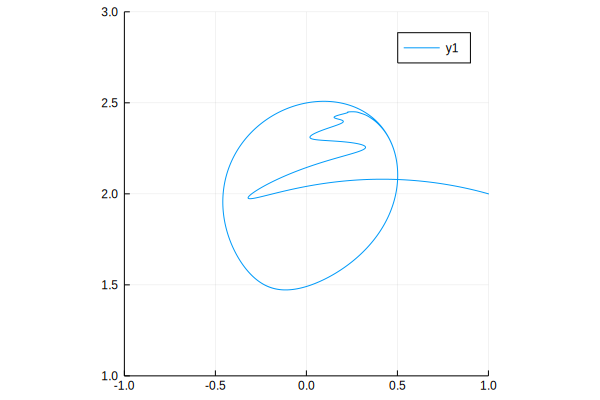

In [22]:
xs = Float64[]
zs = Float64[]
for q in qs
    set_configuration!(state, q)
    p = transform(state, point, root_frame(mechanism))
    push!(xs, p.v[1])
    push!(zs, p.v[3])
end

plot(xs, zs, xlim=(-1, 1), ylim=(1, 3), aspect_ratio=:equal)